In [21]:
from __future__ import print_function

import sys, os

import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

import keras_uncertainty
from keras_uncertainty.utils import numpy_negative_log_likelihood, numpy_entropy
from keras_uncertainty.layers import DropConnectConv2D, DropConnectDense
from keras_uncertainty.models import MCDropoutClassifier
from keras_uncertainty.utils import numpy_regression_nll

import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Model, Sequential
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


In [22]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    #print(data_frame.head(10))
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')

x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
print(x_train.head(10))
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)
print(q_train.head(10))

x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

x_train = x_scaler.fit_transform(x_train)
q_train = q_scaler.fit_transform(q_train)

x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)


          0         1         2         3         4         5         6  \
0  0.398812  0.431706 -0.499640 -0.207795 -0.753744  0.415787  0.464561   
1  0.273052  0.597029 -0.465943 -0.081651 -0.790698  0.448379  0.408767   
2  0.106506  0.717667 -0.421317  0.046245 -0.810690  0.471352  0.344204   
3 -0.086611  0.783325 -0.369571  0.173150 -0.813291  0.484214  0.272257   
4 -0.289816  0.788397 -0.315122  0.296341 -0.798447  0.486689  0.194468   
5  0.320593  0.494222 -0.523277 -0.148793 -0.734773  0.363151  0.553257   
6  0.180242  0.636809 -0.485670 -0.022604 -0.761616  0.409540  0.501708   
7  0.006076  0.731316 -0.439002  0.104069 -0.772120  0.447143  0.439396   
8 -0.187041  0.769676 -0.387257  0.228510 -0.766060  0.475153  0.367657   
9 -0.382626  0.748617 -0.334850  0.348049 -0.743565  0.492970  0.288031   

          7         8  
0  0.000080  0.000012  
1  0.000080  0.000012  
2  0.000080  0.000012  
3  0.000080  0.000012  
4  0.000080  0.000012  
5  0.000087  0.000013  
6  0.0

In [24]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()
        

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(DropConnectDense(num_neurons, activation='relu', input_shape=(input_shape,), prob=0.1))
            else:
                model.add(DropConnectDense(num_neurons, activation='relu', prob=0.1))

            #model.add(BatchNormalization())
            #num_neurons= num_neurons + 32
            Flatten()

        model.add(DropConnectDense(output_shape, activation='sigmoid', prob=0.1))
        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [56]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  1.1}

model = model_builder(9, 18)(**HYPERPARAMETERS)
hist = model.fit(x_train, q_train, epochs = 200, batch_size = 128, verbose = 1, validation_data=(x_test, q_test))




model.save("ik-rh5-leg-5steps_dropconnect.h5")

Train on 15625 samples, validate on 4096 samples
Epoch 1/200
15625/15625 [==============================] - 1s 57us/step - loss: 0.0908 - mae: 0.2497 - val_loss: 0.0670 - val_mae: 0.2138
Epoch 2/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0676 - mae: 0.2095 - val_loss: 0.0505 - val_mae: 0.1816
Epoch 3/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0589 - mae: 0.1936 - val_loss: 0.0428 - val_mae: 0.1675
Epoch 4/200
15625/15625 [==============================] - 0s 26us/step - loss: 0.0524 - mae: 0.1821 - val_loss: 0.0306 - val_mae: 0.1397
Epoch 5/200
15625/15625 [==============================] - 0s 26us/step - loss: 0.0451 - mae: 0.1676 - val_loss: 0.0277 - val_mae: 0.1346
Epoch 6/200
15625/15625 [==============================] - 0s 26us/step - loss: 0.0417 - mae: 0.1610 - val_loss: 0.0209 - val_mae: 0.1171
Epoch 7/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0382 - mae: 0.1533 - val_loss: 0.0181 - v

15625/15625 [==============================] - 0s 28us/step - loss: 0.0159 - mae: 0.0960 - val_loss: 0.0108 - val_mae: 0.0815
Epoch 60/200
15625/15625 [==============================] - 0s 28us/step - loss: 0.0154 - mae: 0.0944 - val_loss: 0.0091 - val_mae: 0.0755
Epoch 61/200
15625/15625 [==============================] - 0s 30us/step - loss: 0.0153 - mae: 0.0940 - val_loss: 0.0101 - val_mae: 0.0807
Epoch 62/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0149 - mae: 0.0922 - val_loss: 0.0099 - val_mae: 0.0792
Epoch 63/200
15625/15625 [==============================] - 0s 27us/step - loss: 0.0150 - mae: 0.0926 - val_loss: 0.0084 - val_mae: 0.0722
Epoch 64/200
15625/15625 [==============================] - 0s 26us/step - loss: 0.0149 - mae: 0.0926 - val_loss: 0.0063 - val_mae: 0.0631
Epoch 65/200
15625/15625 [==============================] - 0s 27us/step - loss: 0.0160 - mae: 0.0952 - val_loss: 0.0110 - val_mae: 0.0823
Epoch 66/200
15625/15625 [==============

Epoch 118/200
15625/15625 [==============================] - 0s 26us/step - loss: 0.0108 - mae: 0.0758 - val_loss: 0.0074 - val_mae: 0.0657
Epoch 119/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0110 - mae: 0.0770 - val_loss: 0.0077 - val_mae: 0.0664
Epoch 120/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0107 - mae: 0.0760 - val_loss: 0.0119 - val_mae: 0.0849
Epoch 121/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0107 - mae: 0.0757 - val_loss: 0.0126 - val_mae: 0.0862
Epoch 122/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0103 - mae: 0.0746 - val_loss: 0.0105 - val_mae: 0.0772
Epoch 123/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0101 - mae: 0.0737 - val_loss: 0.0093 - val_mae: 0.0747
Epoch 124/200
15625/15625 [==============================] - 0s 24us/step - loss: 0.0110 - mae: 0.0763 - val_loss: 0.0138 - val_mae: 0.0879
Epoch 125/200
15625/

15625/15625 [==============================] - 0s 25us/step - loss: 0.0082 - mae: 0.0646 - val_loss: 0.0173 - val_mae: 0.0989
Epoch 177/200
15625/15625 [==============================] - 0s 26us/step - loss: 0.0087 - mae: 0.0664 - val_loss: 0.0171 - val_mae: 0.0976
Epoch 178/200
15625/15625 [==============================] - 0s 26us/step - loss: 0.0086 - mae: 0.0662 - val_loss: 0.0168 - val_mae: 0.0976
Epoch 179/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0083 - mae: 0.0650 - val_loss: 0.0094 - val_mae: 0.0740
Epoch 180/200
15625/15625 [==============================] - 0s 25us/step - loss: 0.0088 - mae: 0.0668 - val_loss: 0.0155 - val_mae: 0.0948
Epoch 181/200
15625/15625 [==============================] - 0s 26us/step - loss: 0.0088 - mae: 0.0663 - val_loss: 0.0114 - val_mae: 0.0820
Epoch 182/200
15625/15625 [==============================] - 0s 28us/step - loss: 0.0081 - mae: 0.0644 - val_loss: 0.0086 - val_mae: 0.0694
Epoch 183/200
15625/15625 [=======

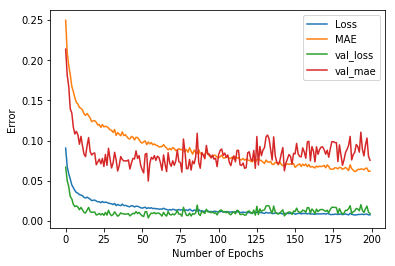

In [57]:
epoch  = list(range(0, 200, 1))
#print(epoch)
#print(hist.history['loss'])
plt.figure()
plt.plot( epoch, hist.history['loss'],     label = 'Loss')
plt.plot( epoch, hist.history['mae'],      label = 'MAE')
plt.plot( epoch, hist.history['val_loss'], label = 'val_loss')
plt.plot( epoch, hist.history['val_mae'],  label = 'val_mae')
plt.xlabel("Number of Epochs")
plt.ylabel("Error")
plt.legend(loc='upper right')


In [26]:
q_pred = model.predict(x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(q_test, q_pred)

print("Testing MAE: {:.5f}".format(global_mae))

# Compute MAE for each output independently.
for i in range(q_test.shape[1]):
    norm_mae_i = mean_absolute_error(q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))



Testing MAE: 0.07216
Q feature 0 has unnorm MAE: 0.0872 (Range -0.7330 to 0.4398) normalized MAE: 0.0743
Q feature 1 has unnorm MAE: 0.0692 (Range -0.3840 to 0.5792) normalized MAE: 0.0718
Q feature 2 has unnorm MAE: 0.0495 (Range -0.8200 to -0.0680) normalized MAE: 0.0659
Q feature 3 has unnorm MAE: 0.0499 (Range -0.8381 to -0.0792) normalized MAE: 0.0657
Q feature 4 has unnorm MAE: 0.0055 (Range 0.0070 to 0.0907) normalized MAE: 0.0653
Q feature 5 has unnorm MAE: 0.0384 (Range 0.0000 to 1.0000) normalized MAE: 0.0384
Q feature 6 has unnorm MAE: 0.0038 (Range -0.0822 to 0.0000) normalized MAE: 0.0467
Q feature 7 has unnorm MAE: 0.0032 (Range 0.0000 to 0.0782) normalized MAE: 0.0414
Q feature 8 has unnorm MAE: 0.0991 (Range -0.7850 to 0.4710) normalized MAE: 0.0789
Q feature 9 has unnorm MAE: 0.1168 (Range -0.7850 to 0.4710) normalized MAE: 0.0930
Q feature 10 has unnorm MAE: 0.1017 (Range -0.5905 to 0.8678) normalized MAE: 0.0697
Q feature 11 has unnorm MAE: 0.1088 (Range -0.5744 to 0

In [31]:
from keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from keras_uncertainty.models import MCDropoutRegressor
from sklearn.preprocessing import MinMaxScaler

def test_mcdropout_regressor(): 
    mc_model = MCDropoutRegressor(model)
    
    inp = x_test
    #print("test array:", inp)  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    #print("shape of DF:", len(mean))
    #print("single values in mean array:", mean[])
    #print("shape of STD:", len(std))
    #print("One-sample prediction mean: {}".format(mean))
    #print("One-sample prediction std: {}".format(std))
    
    q_pred_unnormalised = q_scaler.inverse_transform(mean)    
    global_mae = mean_absolute_error(q_test, mean)
    print("Testing MAE: {:.5f}".format(global_mae))

    return mean, std


mean, std = test_mcdropout_regressor()

q_pred_unnorm = q_scaler.inverse_transform(mean)

print("NLL: {:.5f}".format(numpy_regression_nll(q_unnorm, q_pred_unnorm, std**2)))
    

Testing MAE: 0.06528
NLL: -2.21908


In [ ]:
import matplotlib.pyplot as plt

result_mean_df = pd.DataFrame(mean)
result_std_df = pd.DataFrame(std)
result_ground_df = pd.DataFrame(q_unnorm)
result_before_df = pd.DataFrame(q_pred_unnorm)


plot_df = pd.DataFrame()
filename = "Graphs/Dropconnect/MCDropconnect_Results_Q_Feature_"

for i in range (0, 18):
    plot_df['Train Data'] = result_ground_df[i]
    plot_df['Before MCDropConnect Prediction'] = result_before_df[i]
    plot_df['Mean Prediction'] = result_mean_df[i]
    plot_df['OneSigmaMin'] = result_mean_df[i] - result_std_df[i]
    plot_df['OneSigmaMax'] = result_mean_df[i] + result_std_df[i]

    #print(plot_df.head(4))
    plt.figure()
    ax = plot_df.iloc[0:99].plot()    
    ax.set_xlabel("Number of Samples")
    ax.set_ylabel("Radians")
    plt.legend(loc="lower right", prop={'size':7})
    fileName = filename + str(i)
    plt.savefig(fileName)
